In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_scores = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date > one_year_ago)
    .order_by(Measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_scores, columns=["Date", "Precipitation"])

# Sort the dataframe by date
precip_df = precip_df.sort_values("Date").dropna().set_index("Date")

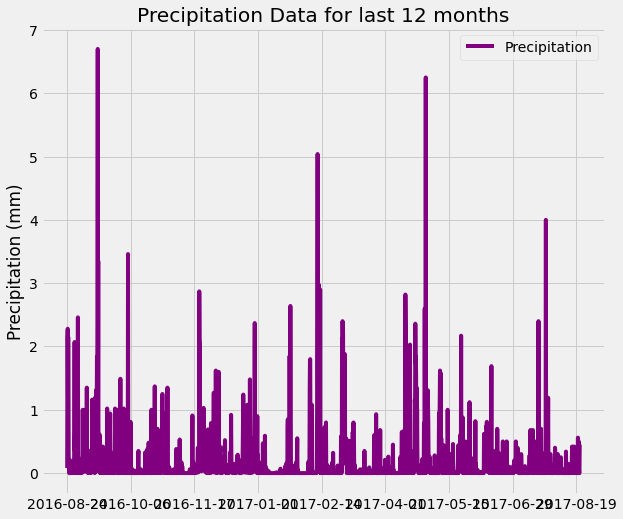

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(color="purple", figsize=(9, 8))
plt.title("Precipitation Data for last 12 months")
plt.ylabel("Precipitation (mm)")
plt.xlabel("")
plt.savefig("./images/precip.png")

In [ ]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(Station).count()

stations_count

9

In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()